# HW3 Long read analysis

In [12]:
import pysam
import seaborn as sns
import numpy as np
import pandas as pd

from collections import Counter

## Part 1. Pac Bio

In [5]:
!minimap2 -x "map-pb" -d "./data/hw3/pb_ref_index.mmi" "./data/hw3/reference.fasta"

[M::mm_idx_gen::0.176*0.90] collected minimizers
[M::mm_idx_gen::0.194*1.09] sorted minimizers
[M::main::0.274*1.05] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.281*1.05] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468; total length: 4639675
[M::main] Version: 2.17-r974-dirty
[M::main] CMD: minimap2 -x map-pb -d ./data/hw3/pb_ref_index.mmi ./data/hw3/reference.fasta
[M::main] Real time: 0.297 sec; CPU: 0.308 sec; Peak RSS: 0.053 GB


In [21]:
!minimap2 -ax "map-pb" "./data/hw3/pb_ref_index.mmi" "./data/hw3/pacbio_40x.fq.gz" | samtools view -bS - | samtools sort -o "./data/hw3/pb_alignment.bam"

[M::main::0.097*0.77] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.104*0.79] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.111*0.80] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468; total length: 4639675
[M::worker_pipeline::84.519*1.73] mapped 41447 sequences
[M::main] Version: 2.17-r974-dirty
[M::main] CMD: minimap2 -ax map-pb ./data/hw3/pb_ref_index.mmi ./data/hw3/pacbio_40x.fq.gz
[M::main] Real time: 84.549 sec; CPU: 146.392 sec; Peak RSS: 1.466 GB


In [27]:
!samtools index "./data/hw3/pb_alignment.bam"

In [28]:
!samtools flagstat "./data/hw3/pb_alignment.bam"

52081 + 0 in total (QC-passed reads + QC-failed reads)
1736 + 0 secondary
8898 + 0 supplementary
0 + 0 duplicates
51199 + 0 mapped (98.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [36]:
pb_alignment = "./data/hw3/pb_alignment.bam"
reference_path = "./data/hw3/reference.fasta"

pb_bam = pysam.AlignmentFile(pb_alignment, "rb")
pb_contig = pb_bam.references[0]
ref_fasta = pysam.FastaFile(reference_path)
seq = ref_fasta.fetch(pb_contig)
print(pb_contig)

gi|48994873|gb|U00096.2|


In [30]:
def calculate_coverage(bamfile, contig, segment_lenght=5000):
    total_cov = []
    current_cov = 0
    prev_pos = 0
    skipped = 1
    
    for pile in bamfile.pileup(contig):
        current_pos = pile.pos
        if prev_pos + 1 != current_pos:
            skipped += current_pos - prev_pos - 1
        if current_pos // segment_lenght > prev_pos // segment_lenght:
            total_cov.append(current_cov / segment_lenght)
            current_cov = 0
        current_cov += pile.n
        prev_pos = current_pos
    coverage_frac = 1 - skipped / bamfile.lengths[0]
    return total_cov, coverage_frac * 100

Доля покрытия: 100.0 %. Среднее покрытие: 40.12735469255663


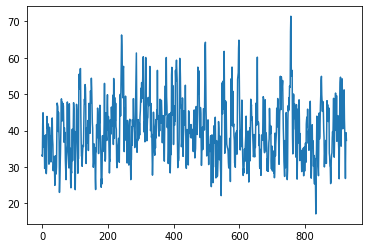

In [31]:
total_cov, coverage_percent = calculate_coverage(pb_bam, pb_contig)
mean_coverage = np.array(total_cov).mean()
print(f'Доля покрытия: {coverage_percent} %. Среднее покрытие: {mean_coverage}')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

In [61]:
def get_avg_error(bamfile, contig, ref_seq):
    cumulative_error = 0
    total_read_len = 0
    
    ref_len = len(ref_seq)
    ref_gen = enumerate(ref_seq)
    pos, base = next(ref_gen)
    
    for read in bamfile.fetch(contig):
        total_read_len += read.query_alignment_length
        
    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
            
        q_seq = pileupcolumn.get_query_sequences(add_indels=True)
        for seq in q_seq:
            if len(seq) == 1:
                ncl = seq.upper()
                if ncl != base:
                    cumulative_error += 1
            else:
                n_errors = int(''.join(filter(str.isdigit, seq)))
                cumulative_error += n_errors
    return cumulative_error / total_read_len

In [62]:
avg_err = get_avg_error(pb_bam, pb_contig, seq)
print('Average error %: ', avg_err * 100)

Average error %:  5.040369419676032


In [38]:
def calculate_indel_stats_from_cigar(bamfile, contig):
    indels_lengths = []
    for read in bamfile.fetch(contig):
        for operation, length in read.cigartuples:
            if operation == 1 or operation == 2:
                indels_lengths.append(length)
        
    return sum(indels_lengths) / len(indels_lengths)

In [39]:
indel_length = calculate_indel_stats_from_cigar(pb_bam, pb_contig)
print(f'Average indel length counted with cigar strings: {indel_length:.2f}')

Average indel length counted with cigar strings: 1.44


In [40]:
def build_substitution_matrix(bamfile, contig, ref_seq):
    substitution_matrix = pd.DataFrame(
        {'A': [0,0,0,0,0], 'C': [0,0,0,0,0], 'G': [0,0,0,0,0], 'T': [0,0,0,0,0], '-': [0,0,0,0,0]}, 
        index=['A', 'C', 'G', 'T', '-']
    )
    
    ref_gen = enumerate(ref_seq)
    pos, base = next(ref_gen)

    for pileupcolumn in bamfile.pileup(contig):
        while pos != pileupcolumn.reference_pos:
            pos, base = next(ref_gen)
            
        q_seq = pileupcolumn.get_query_sequences(add_indels=True)
        for seq in q_seq:
            if len(seq) == 1:
                ncl = seq.upper()
                if ncl != base and ncl != 'N':
                    if ncl == '*':
                        substitution_matrix.at[base, '-'] += 1
                    else:
                        substitution_matrix.at[base, ncl] += 1
            elif seq[1] == '+':
                ncl_list = list(filter(lambda x: x.isalpha(), seq[2:]))
                for ncl in ncl_list:
                    substitution_matrix.at['-', ncl.upper()] += 1
                
    return substitution_matrix

In [41]:
mtrx = build_substitution_matrix(pb_bam, pb_contig, seq)
print(mtrx)

         A        C        G        T       -
A        0    47895    43676    50176  313172
C    60676        0    55743    51433  454375
G    52398    56438        0    58450  531406
T    50584    43752    47209        0  357002
-  1308402  1528698  1646443  1261944       0


## Part 2. Oxford Nanopore

In [42]:
!minimap2 -x "map-ont" -d "./data/hw3/ont_ref_index.mmi" "./data/hw3/reference.fasta"

[M::mm_idx_gen::0.174*1.09] collected minimizers
[M::mm_idx_gen::0.204*1.34] sorted minimizers
[M::main::0.299*1.20] loaded/built the index for 1 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.308*1.19] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352; total length: 4639675
[M::main] Version: 2.17-r974-dirty
[M::main] CMD: minimap2 -x map-ont -d ./data/hw3/ont_ref_index.mmi ./data/hw3/reference.fasta
[M::main] Real time: 0.325 sec; CPU: 0.384 sec; Peak RSS: 0.058 GB


In [43]:
!minimap2 -ax "map-ont" "./data/hw3/ont_ref_index.mmi" "./data/hw3/ONT_2D.fastq.gz" | samtools view -bS - | samtools sort -o "./data/hw3/ont_alignment.bam"

[M::main::0.092*1.03] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.104*1.03] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.114*1.02] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352; total length: 4639675
[M::worker_pipeline::33.208*1.67] mapped 30810 sequences
[M::main] Version: 2.17-r974-dirty
[M::main] CMD: minimap2 -ax map-ont ./data/hw3/ont_ref_index.mmi ./data/hw3/ONT_2D.fastq.gz
[M::main] Real time: 33.225 sec; CPU: 55.332 sec; Peak RSS: 0.860 GB


In [44]:
!samtools index "./data/hw3/ont_alignment.bam"

In [45]:
!samtools flagstat "./data/hw3/ont_alignment.bam"

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [53]:
ont_alignment = "./data/hw3/ont_alignment.bam"
reference_path = "./data/hw3/reference.fasta"

ont_bam = pysam.AlignmentFile(ont_alignment, "rb")
ont_contig = ont_bam.references[0]
ref_fasta = pysam.FastaFile(reference_path)
seq = ref_fasta.fetch(pb_contig)
print(ont_contig)

gi|48994873|gb|U00096.2|


Доля покрытия: 100.0 %. Среднее покрытие: 27.99881769147789


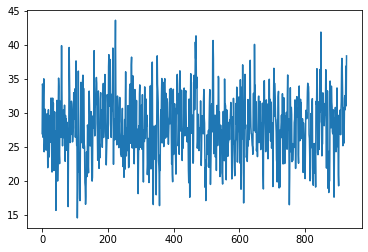

In [54]:
total_cov, coverage_percent = calculate_coverage(ont_bam, ont_contig)
mean_coverage = np.array(total_cov).mean()
print(f'Доля покрытия: {coverage_percent} %. Среднее покрытие: {mean_coverage}')
sns.lineplot(x=range(len(total_cov)), y=total_cov)

In [63]:
avg_err = get_avg_error(ont_bam, ont_contig, seq)
print('Average error %: ', avg_err * 100)

Average error %:  5.365874019344946


In [56]:
indel_length = calculate_indel_stats_from_cigar(ont_bam, ont_contig)
print(f'Average indel length counted with cigar strings: {indel_length:.2f}')

Average indel length counted with cigar strings: 1.87


In [57]:
mtrx = build_substitution_matrix(ont_bam, ont_contig, seq)
print(mtrx)

        A       C       G       T       -
A       0   17662   71509   15743  748805
C   18809       0   12653   53596  709977
G   49966   13707       0   18338  699991
T   16004   71669   17121       0  748596
-  193409  180206  190250  179138       0
